In [ ]:
#@title Import python packages

import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)

In [ ]:
#@title Mount Google Drive

# Before running, add "EventData" folder as Google Drive Shortcut to your Google My Drive Directory

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the data path directly
data_path = "/content/drive/MyDrive/EventData"

# Change the current directory to the data path
os.chdir(data_path)
print(f"Success - Drive mounted at {data_path}!")

# List files and folders contained in the current / working directory
os.listdir()

Mounted at /content/drive
Success - Drive mounted at /content/drive/MyDrive/EventData!


['incident.csv',
 'all_mmg_incident.csv',
 'All MMG INC  Data Analysis As Of Mar 25 2024',
 'Events Data Analysis As Of Mar 25 2024',
 'all_mmg_incident42524.csv',
 'rejected_cgevents.csv',
 'all_cgevents.csv',
 'newform.csv',
 'Campus Group Events 2022 thru apr 2024',
 'FTE Analysis & Summary.gsheet',
 'full_year.csv',
 'jan15-apr25.csv',
 'All MMG INC  Data Analysis Thru Apr 25 2024']

In [ ]:
#@title Import & Clean Up Dataset
data = pd.read_csv("all_mmg_incident42524.csv", encoding='ISO-8859-1')

# Convert date time
data['u_event_start'] = pd.to_datetime(data['u_event_start'])
data['u_event_end'] = pd.to_datetime(data['u_event_end'])
data['opened_at'] = pd.to_datetime(data['opened_at'])
data['resolved_at'] = pd.to_datetime(data['resolved_at'])

# Remove rows where u_order_status is "Duplicate"
data = data[data['u_order_status'] != "Duplicate"]

# Add an 'event_duration' column calculated as the difference in hours between 'u_event_end' and 'u_event_start'
data['event_duration'] = (data['u_event_end'] - data['u_event_start']).dt.total_seconds() / 3600


data

,opened_at,resolved_at,number,caller_id,assigned_to,assignment_group,short_description,incident_state,u_order_status,category,subcategory,u_item,u_event_start,u_event_end,u_echo_scheduled,location,resolved_by,event_duration
0,2024-04-09 15:07:51,NaT,INC383408,Melina Denebeim,Steven Hudock,Multimedia Services,EventID: 67535 - AI in Asset Management Confer...,New,New,Multimedia Services,Service Request,AV Technician,2024-06-06 08:00:00,2024-06-06 13:30:00,False,David Geffen Hall/330,NaN,5.5
1,2023-11-17 11:17:17,NaT,INC378235,Sacha Seecharran,Steven Hudock,Multimedia Services,"EventID: 48099 - CBS Reunion - G-120, 6/1/24, ...",New,New,Multimedia Services,Service Request,AV Technician,2024-06-01 07:30:00,2024-06-01 18:00:00,False,David Geffen Hall/120,NaN,10.5
2,2023-12-21 09:53:03,NaT,INC379628,Kevin Erixson,Steven Hudock,Multimedia Services,EventID: 59383 - AI and Algorithms (working ti...,New,Acknowledged,Multimedia Services,Tech Assist,Media Assist,2024-05-29 07:30:00,2024-05-29 18:00:00,True,David Geffen Hall/330,NaN,10.5
3,2023-12-21 10:02:04,NaT,INC379629,Kevin Erixson,Steven Hudock,Multimedia Services,EventID: 59382 - AI and Algorithms (working ti...,New,Acknowledged,Multimedia Services,Tech Assist,Media Assist,2024-05-28 07:30:00,2024-05-28 18:00:00,True,David Geffen Hall/330,NaN,10.5
4,2024-04-23 19:32:14,NaT,INC383916,Julie Berger,Steven Hudock,Multimedia Services,EventID: DFI TLDR Conference Day 2 / ER: 04/17...,New,New,Multimedia Services,Equipment Request,See MMG Item,2024-05-17 08:00:00,2024-05-17 17:00:00,True,David Geffen Hall/620,NaN,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5789,2022-02-11 09:56:01,2022-02-18 14:29:08,INC347904,Miguel Cruz,Ted Wohlsen,Multimedia Services,SR: Digital Signage on Geffen 7th & 8th Floor...,Closed,Resolved,Multimedia Services,Service Request,AV Technician,NaT,NaT,False,NaN,Ted Wohlsen,NaN
5790,2022-02-16 07:24:04,2022-03-11 08:18:13,INC348162,Daniel Russman,Ted Wohlsen,Multimedia Services,PollEV not working in Zoom,Closed,Resolved,Computing,Application,Poll Everywhere,NaT,NaT,False,David Geffen Hall/490,Ted Wohlsen,NaN
5791,2022-01-31 15:05:13,2022-01-31 15:06:38,INC347178,Lubna Patwa,Johanna Gonzalez,Multimedia Services,Recordings inquiry,Closed,Resolved,Multimedia Services,Class Recording,ECHO360,NaT,NaT,False,NaN,Johanna Gonzalez,NaN
5792,2022-02-08 14:12:39,2022-02-08 14:15:38,INC347686,Sean Hardwick,Ted Wohlsen,Multimedia Services,Help Call: Computer was turned off,Closed,Resolved,Multimedia Services,Help Call,Equipment - PC,NaT,NaT,False,NaN,Ted Wohlsen,NaN


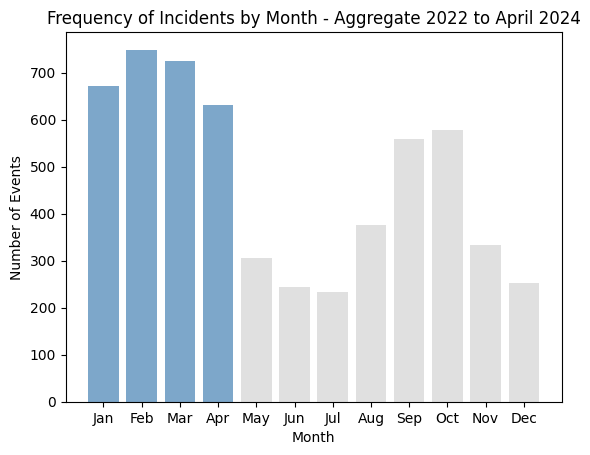

In [ ]:
# @title Frequency of Incidents by Month 2022-2024

# Extract the month from the 'opened_at' column
data['event_month'] = data['opened_at'].dt.month

# Calculate the histogram data
counts, bins = np.histogram(data['event_month'], bins=12, range=(1, 13))

# Define colors for each bin
colors = ['steelblue' if 1 <= bin < 5 else 'lightgray' for bin in bins[:-1]]

# Plot using bar plot
plt.bar(range(1, 13), counts, color=colors, width=0.8, alpha=0.7)

plt.title('Frequency of Incidents by Month - Aggregate 2022 to April 2024')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

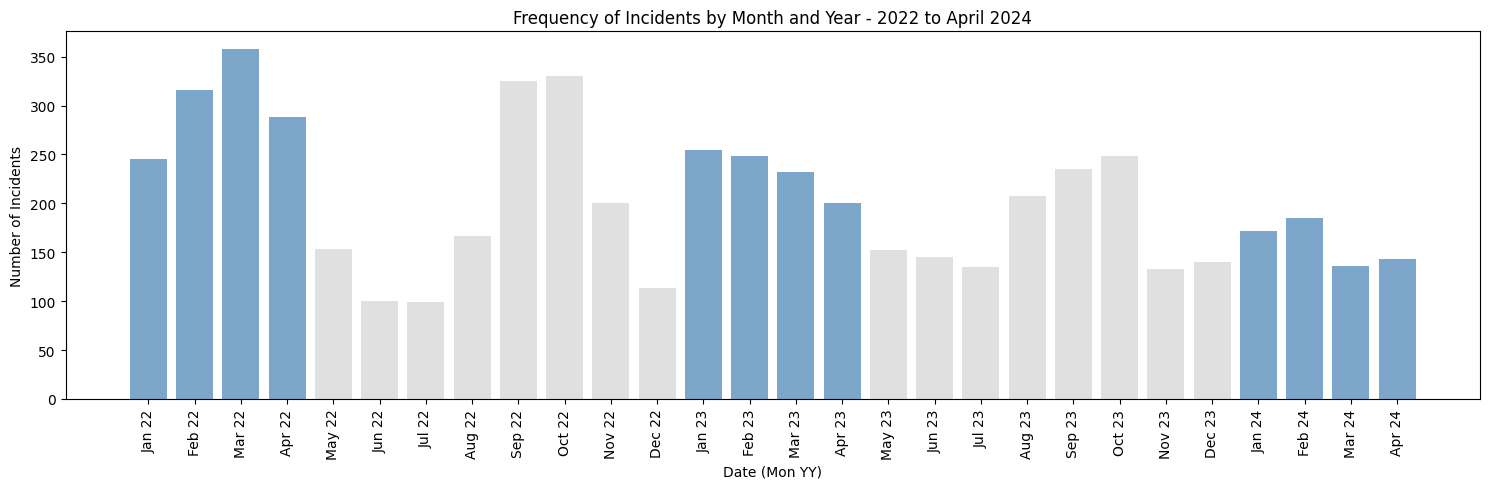

In [ ]:
# @title Frequency of Incidents by Month and Year with Regression Trend Line


# Create a 'year_month' column for a unique year-month identifier
data['year_month'] = data['opened_at'].dt.to_period('M')

# Generate a comprehensive index from the earliest to the latest month in your data
min_month = data['year_month'].min()
max_month = data['year_month'].max()
all_months = pd.period_range(min_month, max_month, freq='M')

# Count the occurrences for each month and reindex with the comprehensive index, filling missing values with 0
month_counts = data['year_month'].value_counts().reindex(all_months, fill_value=0)

# Adjusting figure size for better readability
plt.figure(figsize=(15, 5))

# Define colors for each month: highlight Jan, Feb, Mar, Apr
colors = ['steelblue' if month.month in [1, 2, 3, 4] else 'lightgray' for month in month_counts.index]

# Plotting the bars with 'center' alignment
plt.bar(month_counts.index.astype(str), month_counts.values, width=0.8, align='center', alpha=0.7, color=colors)

# Formatting the x-axis labels to use "Mon YY" format
x_labels = [date.strftime('%b %y') for date in month_counts.index.to_timestamp()]
x = np.arange(len(month_counts))  # numeric x-axis for plotting
plt.xticks(x, x_labels, rotation=90)

plt.title('Frequency of Incidents by Month and Year - 2022 to April 2024')
plt.xlabel('Date (Mon YY)')
plt.ylabel('Number of Incidents')

# Adjust the margin to better accommodate the rotated x-axis labels
plt.gcf().subplots_adjust(bottom=0.25)

plt.tight_layout()
plt.show()



In [ ]:
# List of specific 'assigned_to' values to rename
rename_assigned_to = {
    "Daniel Silver": "Temp Resource",
    "Jonathan Plummer": "Temp Resource",
    "Kristina Teschner": "Temp Resource"
}

# Rename specific 'assigned_to' values
data['assigned_to'] = data['assigned_to'].replace(rename_assigned_to)

# List of 'assigned_to' values to exclude
exclude_assigned_to = [
    "Amanda Shelton",
    "Otoniel Zorrilla",
    "Ke Wen Zeng",
    "Angel Yau",
    "Charles Modica"
]

# Filter out the rows with the specified 'assigned_to' values
filtered_data = data[~data['assigned_to'].isin(exclude_assigned_to)]

# Define the start and end months and days for the date range
start_month, start_day = 1, 15  # January 15
end_month, end_day = 4, 25      # April 25

# Apply date range filter to the already filtered data based on 'assigned_to'
filtered_data = filtered_data[
    ((filtered_data['opened_at'].dt.month > start_month) |
    ((filtered_data['opened_at'].dt.month == start_month) & (filtered_data['opened_at'].dt.day >= start_day))) &
    ((filtered_data['opened_at'].dt.month < end_month) |
    ((filtered_data['opened_at'].dt.month == end_month) & (filtered_data['opened_at'].dt.day <= end_day))) &
    (filtered_data['opened_at'].dt.year.isin([2022, 2023, 2024]))
]

# Group by year
grouped = filtered_data.groupby(filtered_data['opened_at'].dt.year)

# Count unique 'number' identifiers
unique_records_count = grouped['number'].nunique().rename('Unique Records Count')

# Count unique 'assigned_to' identifiers
unique_assigned_to_count = grouped['assigned_to'].nunique().rename('Unique Assigned To Count')

# Calculate average records per 'assigned_to'
average_records_per_assigned_to = (grouped.size() / unique_assigned_to_count).rename('Average Records per Assigned To')

# Combine all the data into one DataFrame
results_table = pd.DataFrame({
    'Unique Records Count': unique_records_count,
    'Unique Assigned To Count': unique_assigned_to_count,
    'Average Records per Assigned To': average_records_per_assigned_to
})

# Round the results and convert to integers to remove decimal places
results_table = results_table.round().astype(int)

# Display the results as a normal table
print(results_table)


           Unique Records Count  Unique Assigned To Count  \
opened_at                                                   
2022                       1093                         7   
2023                        823                         7   
2024                        572                         7   

           Average Records per Assigned To  
opened_at                                   
2022                                   156  
2023                                   118  
2024                                    82  


In [ ]:
# List of specific 'assigned_to' values to rename
rename_assigned_to = {
    "Daniel Silver": "Temp Resource",
    "Jonathan Plummer": "Temp Resource",
    "Kristina Teschner": "Temp Resource"
}

# Rename specific 'assigned_to' values
data['assigned_to'] = data['assigned_to'].replace(rename_assigned_to)

# List of 'assigned_to' values to exclude
exclude_assigned_to = [
    "Amanda Shelton",
    "Otoniel Zorrilla",
    "Ke Wen Zeng",
    "Angel Yau",
    "Charles Modica"
]

# Additional filtering for "Steven Hudock"
specific_assigned_to = "Steven Hudock"

# Apply initial filter to exclude certain 'assigned_to' values
filtered_data = data[~data['assigned_to'].isin(exclude_assigned_to)]

# Define the specific time period for 2024 using Timestamps directly
start_date = pd.Timestamp(year=2024, month=1, day=15)
end_date = pd.Timestamp(year=2024, month=4, day=25)

# Further filter data for the 2024 date range using Timestamp comparison
filtered_data_2024 = filtered_data[
    (filtered_data['opened_at'] >= start_date) &
    (filtered_data['opened_at'] <= end_date)
]

# Split data based on 'Steven Hudock'
data_without_hudock = filtered_data_2024[filtered_data_2024['assigned_to'] != specific_assigned_to]
data_with_hudock = filtered_data_2024[filtered_data_2024['assigned_to'] == specific_assigned_to]

# Calculate metrics
metrics_without_hudock = {
    'Unique Records Count': data_without_hudock['number'].nunique(),
    'Unique Assigned To Count': data_without_hudock['assigned_to'].nunique(),
    'Average Records per Assigned To': len(data_without_hudock) / data_without_hudock['assigned_to'].nunique()
}

metrics_with_hudock = {
    'Unique Records Count': data_with_hudock['number'].nunique(),
    'Unique Assigned To Count': data_with_hudock['assigned_to'].nunique(),  # Should be 1 or 0
    'Average Records per Assigned To': len(data_with_hudock) / data_with_hudock['assigned_to'].nunique() if data_with_hudock['assigned_to'].nunique() > 0 else 0
}

# Creating DataFrame to display results
results_df = pd.DataFrame([metrics_without_hudock, metrics_with_hudock],
                          index=["MMG", "ETG"])

# Round the results and convert to integers to remove decimal places
results_df = results_df.round().astype(int)

# Print the results as a normal table
print(results_df)




     Unique Records Count  Unique Assigned To Count  \
MMG                   417                         6   
ETG                   155                         1   

     Average Records per Assigned To  
MMG                               70  
ETG                              155  


In [ ]:
# List of specific 'assigned_to' values to rename
rename_assigned_to = {
    "Daniel Silver": "Temp Resource",
    "Jonathan Plummer": "Temp Resource",
    "Kristina Teschner": "Temp Resource"
}

# Rename specific 'assigned_to' values
data['assigned_to'] = data['assigned_to'].replace(rename_assigned_to)

# List of 'assigned_to' values to exclude
exclude_assigned_to = [
    "Amanda Shelton",
    "Otoniel Zorrilla",
    "Ke Wen Zeng",
    "Angel Yau",
    "Charles Modica"
]

# Assuming 'opened_at' is already a datetime column, if not use the following line to convert:
# data['opened_at'] = pd.to_datetime(data['opened_at'])

# Filter out the rows with the specified 'assigned_to' values
filtered_data = data[~data['assigned_to'].isin(exclude_assigned_to)]

# Filter for years of interest
years_of_interest = [2022, 2023, 2024]
filtered_data = filtered_data[filtered_data['opened_at'].dt.year.isin(years_of_interest)]

# Count the total records per year
total_records_per_year = filtered_data.groupby(filtered_data['opened_at'].dt.year).size()

# Count records per 'assigned_to' across all years
assigned_records_per_assignee = filtered_data.groupby('assigned_to').size()

# Calculate total records across the years of interest for normalization
total_records_all_years = filtered_data.shape[0]

# Calculate percentage for each 'assigned_to' over the total records
percentage_per_assignee = (assigned_records_per_assignee / total_records_all_years * 100).rename('Percentage of Total Records')

# Create a DataFrame for displaying results
results_df = pd.DataFrame({
    'Assigned Records': assigned_records_per_assignee,
    'Percentage of Total Records': percentage_per_assignee
})

# Calculate the percentage per year for additional detail
for year in years_of_interest:
    yearly_data = filtered_data[filtered_data['opened_at'].dt.year == year]
    yearly_total = yearly_data.shape[0]
    assignee_counts = yearly_data.groupby('assigned_to').size()
    percentage_yearly = (assignee_counts / yearly_total * 100)
    results_df[f'Percentage of Total Records {year}'] = percentage_yearly.round(2)

# Display the results rounded to two decimal places
print(results_df.round(2))


# Output results_df to a CSV file
results_df.to_csv('full_year.csv', index=True)



                     Assigned Records  Percentage of Total Records  \
assigned_to                                                          
Airiayana Sullivan                920                        16.58   
Anibal Vega Montijo               326                         5.87   
Daniel Hetteix                    487                         8.77   
Johanna Gonzalez                  439                         7.91   
Mhyles Mohun                      551                         9.93   
Steven Hudock                    1051                        18.94   
Ted Wohlsen                      1583                        28.52   
Temp Resource                     192                         3.46   

                     Percentage of Total Records 2022  \
assigned_to                                             
Airiayana Sullivan                              14.90   
Anibal Vega Montijo                              6.09   
Daniel Hetteix                                   8.09   
Johanna Gonzal

In [ ]:
# List of specific 'assigned_to' values to rename
rename_assigned_to = {
    "Daniel Silver": "Temp Resource",
    "Jonathan Plummer": "Temp Resource",
    "Kristina Teschner": "Temp Resource"
}

# Rename specific 'assigned_to' values
data['assigned_to'] = data['assigned_to'].replace(rename_assigned_to)

# List of 'assigned_to' values to exclude
exclude_assigned_to = [
    "Amanda Shelton",
    "Otoniel Zorrilla",
    "Ke Wen Zeng",
    "Angel Yau",
    "Charles Modica"
]

# Filter out the rows with the specified 'assigned_to' values
filtered_data = data[~data['assigned_to'].isin(exclude_assigned_to)]

# Define the specific date range for each year
date_ranges = {year: (pd.Timestamp(year=year, month=1, day=15), pd.Timestamp(year=year, month=4, day=25)) for year in [2022, 2023, 2024]}

# Apply date range filters to the data
filtered_data = pd.concat([
    filtered_data[(filtered_data['opened_at'] >= start) & (filtered_data['opened_at'] <= end)]
    for year, (start, end) in date_ranges.items()
])

# Count the total records per year
total_records_per_year = filtered_data.groupby(filtered_data['opened_at'].dt.year).size()

# Count records per 'assigned_to' across all years
assigned_records_per_assignee = filtered_data.groupby('assigned_to').size()

# Calculate total records across the years of interest for normalization
total_records_all_years = filtered_data.shape[0]

# Calculate percentage for each 'assigned_to' over the total records
percentage_per_assignee = (assigned_records_per_assignee / total_records_all_years * 100).rename('Percentage of Total Records')

# Create a DataFrame for displaying results
results_df = pd.DataFrame({
    'Assigned Records': assigned_records_per_assignee,
    'Percentage of Total Records': percentage_per_assignee
})

# Calculate the percentage per year for additional detail
for year in [2022, 2023, 2024]:
    yearly_data = filtered_data[filtered_data['opened_at'].dt.year == year]
    yearly_total = yearly_data.shape[0]
    assignee_counts = yearly_data.groupby('assigned_to').size()
    percentage_yearly = (assignee_counts / yearly_total * 100)
    results_df[f'Percentage of Total Records {year}'] = percentage_yearly.round(2)

# Display the results rounded to two decimal places
print(results_df.round(2))

# Output results_df to a CSV file
results_df.to_csv('jan15-apr25.csv', index=True)


                     Assigned Records  Percentage of Total Records  \
assigned_to                                                          
Airiayana Sullivan                423                        17.16   
Anibal Vega Montijo               143                         5.80   
Daniel Hetteix                    218                         8.84   
Johanna Gonzalez                  179                         7.26   
Mhyles Mohun                      287                        11.64   
Steven Hudock                     453                        18.38   
Ted Wohlsen                       656                        26.61   
Temp Resource                     105                         4.26   

                     Percentage of Total Records 2022  \
assigned_to                                             
Airiayana Sullivan                              14.77   
Anibal Vega Montijo                              6.28   
Daniel Hetteix                                   9.33   
Johanna Gonzal

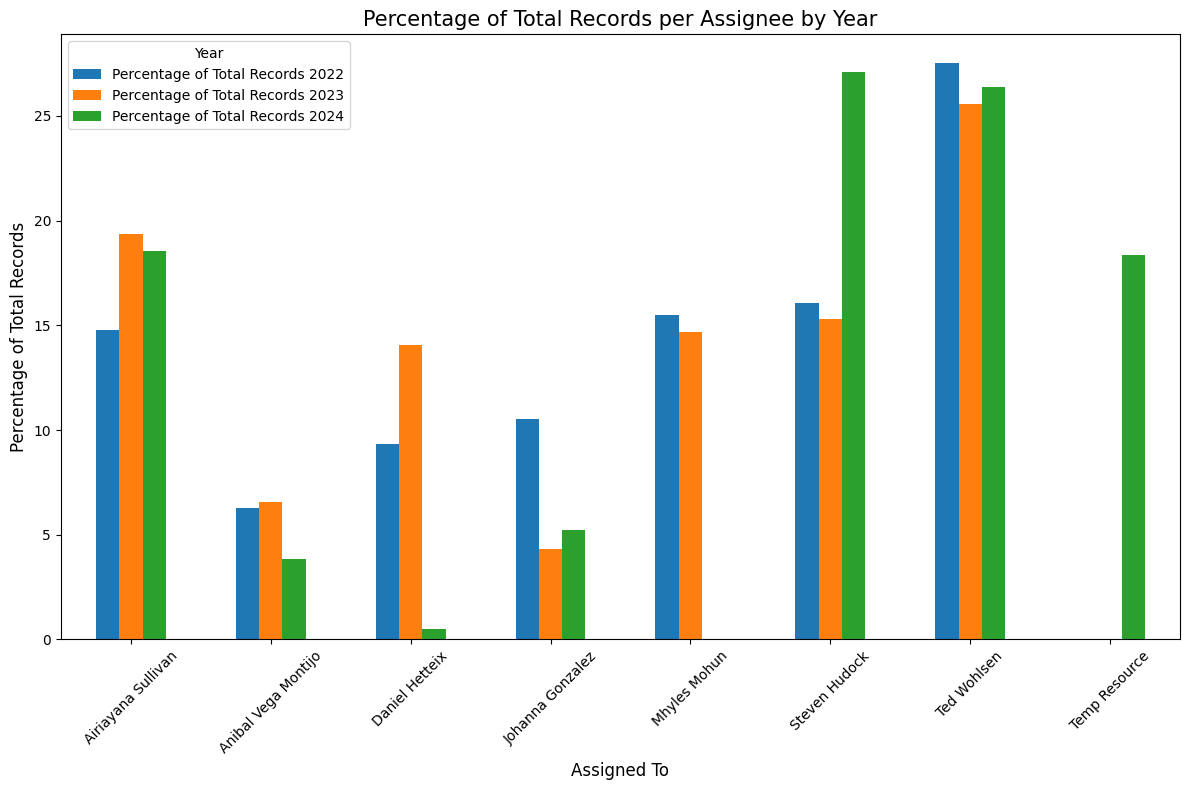

In [ ]:


# Assuming all previous steps are done and you have 'filtered_data' and 'results_df' as described

# Calculate percentages for each year and assign them to the DataFrame
for year in [2022, 2023, 2024]:
    yearly_data = filtered_data[filtered_data['opened_at'].dt.year == year]
    yearly_total = yearly_data.shape[0]
    assignee_counts = yearly_data.groupby('assigned_to').size()
    results_df[f'Percentage of Total Records {year}'] = (assignee_counts / yearly_total * 100).round(2)

# Prepare data for plotting
plot_data = results_df[[f'Percentage of Total Records {year}' for year in [2022, 2023, 2024]]]
plot_data = plot_data.fillna(0)  # Replace NaN with 0 for plotting

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
plot_data.plot(kind='bar', ax=ax)

# Set plot title and labels
ax.set_title('Percentage of Total Records per Assignee by Year', fontsize=15)
ax.set_xlabel('Assigned To', fontsize=12)
ax.set_ylabel('Percentage of Total Records', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
plt.legend(title='Year')

# Show plot
plt.tight_layout()
plt.show()


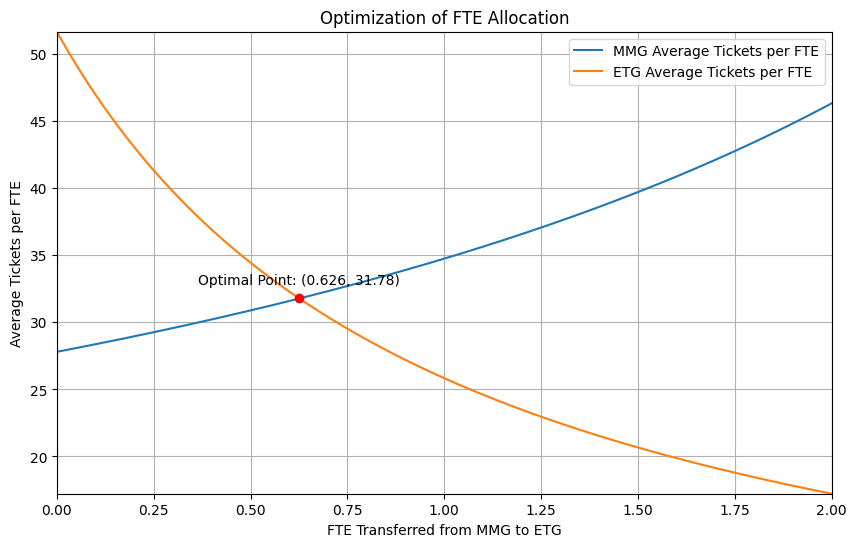

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the FTE transfer range from 0 to 2 for visualization purposes
x_values = np.linspace(0, 2, 400)
tickets_mmg = 417 / 3
tickets_etg = 155 / 3
initial_fte_mmg = 5
initial_fte_etg = 1

# Define the functions for the average number of tickets per FTE using safe array operations
def average_tickets_mmg(x):
    return tickets_mmg / np.maximum(0.1, (initial_fte_mmg - x))

def average_tickets_etg(x):
    return tickets_etg / np.maximum(0.1, (initial_fte_etg + x))

# Function to find where the averages are equal
def equation_to_solve(x):
    return average_tickets_mmg(x) - average_tickets_etg(x)

# Solve for the optimal x using fsolve, starting from an initial guess of 0.5
optimal_x = fsolve(equation_to_solve, 0.5)[0]
optimal_y = average_tickets_mmg(optimal_x)

# Calculate the averages over the range of x values
y_mmg = average_tickets_mmg(x_values)
y_etg = average_tickets_etg(x_values)

# Determine the minimum and maximum values for the y-axis
y_min = min(np.min(y_etg), np.min(y_mmg))
y_max = max(np.max(y_etg), np.max(y_mmg))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_mmg, label='MMG Average Tickets per FTE')
plt.plot(x_values, y_etg, label='ETG Average Tickets per FTE')
plt.title('Optimization of FTE Allocation')
plt.xlabel('FTE Transferred from MMG to ETG')
plt.ylabel('Average Tickets per FTE')
plt.xlim(0, max(x_values))  # Set the limits for the x-axis
plt.ylim(y_min, y_max)  # Set the limits for the y-axis
plt.legend()
plt.grid(True)

# Highlight the intersection point
plt.scatter([optimal_x], [optimal_y], color='red', zorder=5)
plt.annotate(f'Optimal Point: ({optimal_x:.3f}, {optimal_y:.2f})',
             (optimal_x, optimal_y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


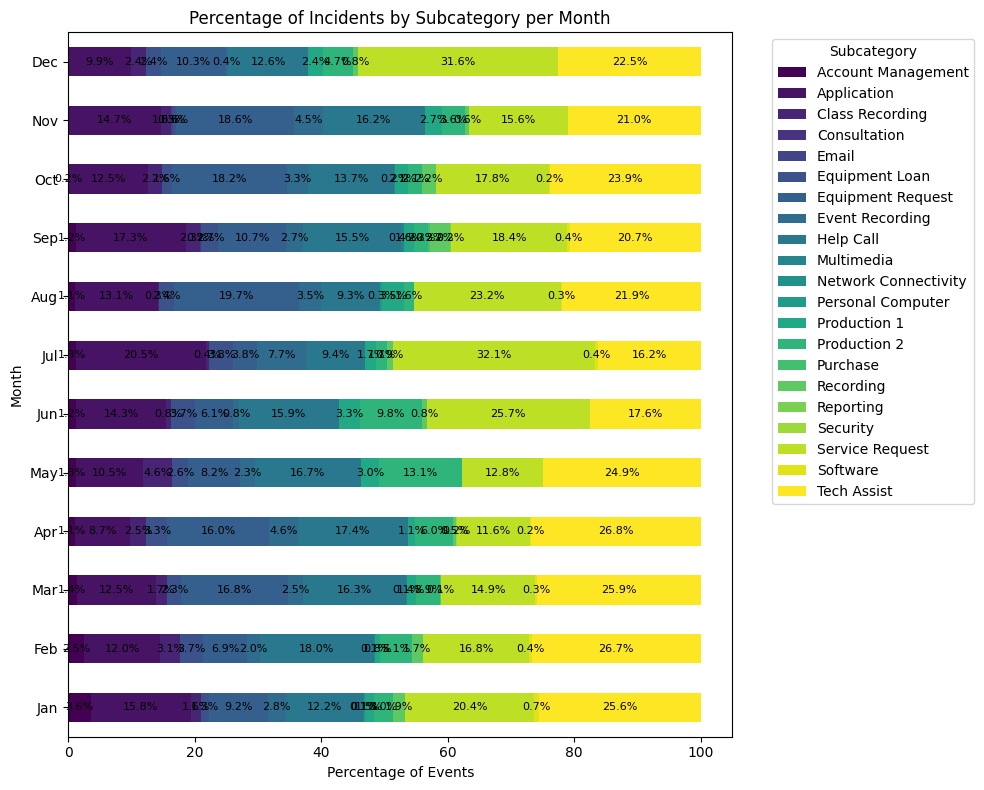

In [ ]:


# Extract the month from the 'opened_at' column
data['event_month'] = data['opened_at'].dt.month

# Group data by month and subcategory, counting occurrences
subcategory_counts = data.groupby(['event_month', 'subcategory']).size().unstack(fill_value=0)

# Normalize the data to get percentages for a 100% stacked bar chart
subcategory_percentages = subcategory_counts.divide(subcategory_counts.sum(axis=1), axis=0) * 100

# Plotting a 100% stacked horizontal bar chart
ax = subcategory_percentages.plot(kind='barh', stacked=True, figsize=(10, 8), colormap='viridis')

plt.title('Percentage of Incidents by Subcategory per Month')
plt.xlabel('Percentage of Events')
plt.ylabel('Month')
plt.yticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding percentage labels inside each bar
for n, rect in enumerate(ax.patches):
    # Width of the bar section
    width = rect.get_width()
    if width > 0:  # Ensure that labels are only put on visible bars
        x = rect.get_x() + width / 2
        y = rect.get_y() + rect.get_height() / 2
        label = f"{width:.1f}%"  # Format label to 1 decimal place
        ax.text(x, y, label, ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()


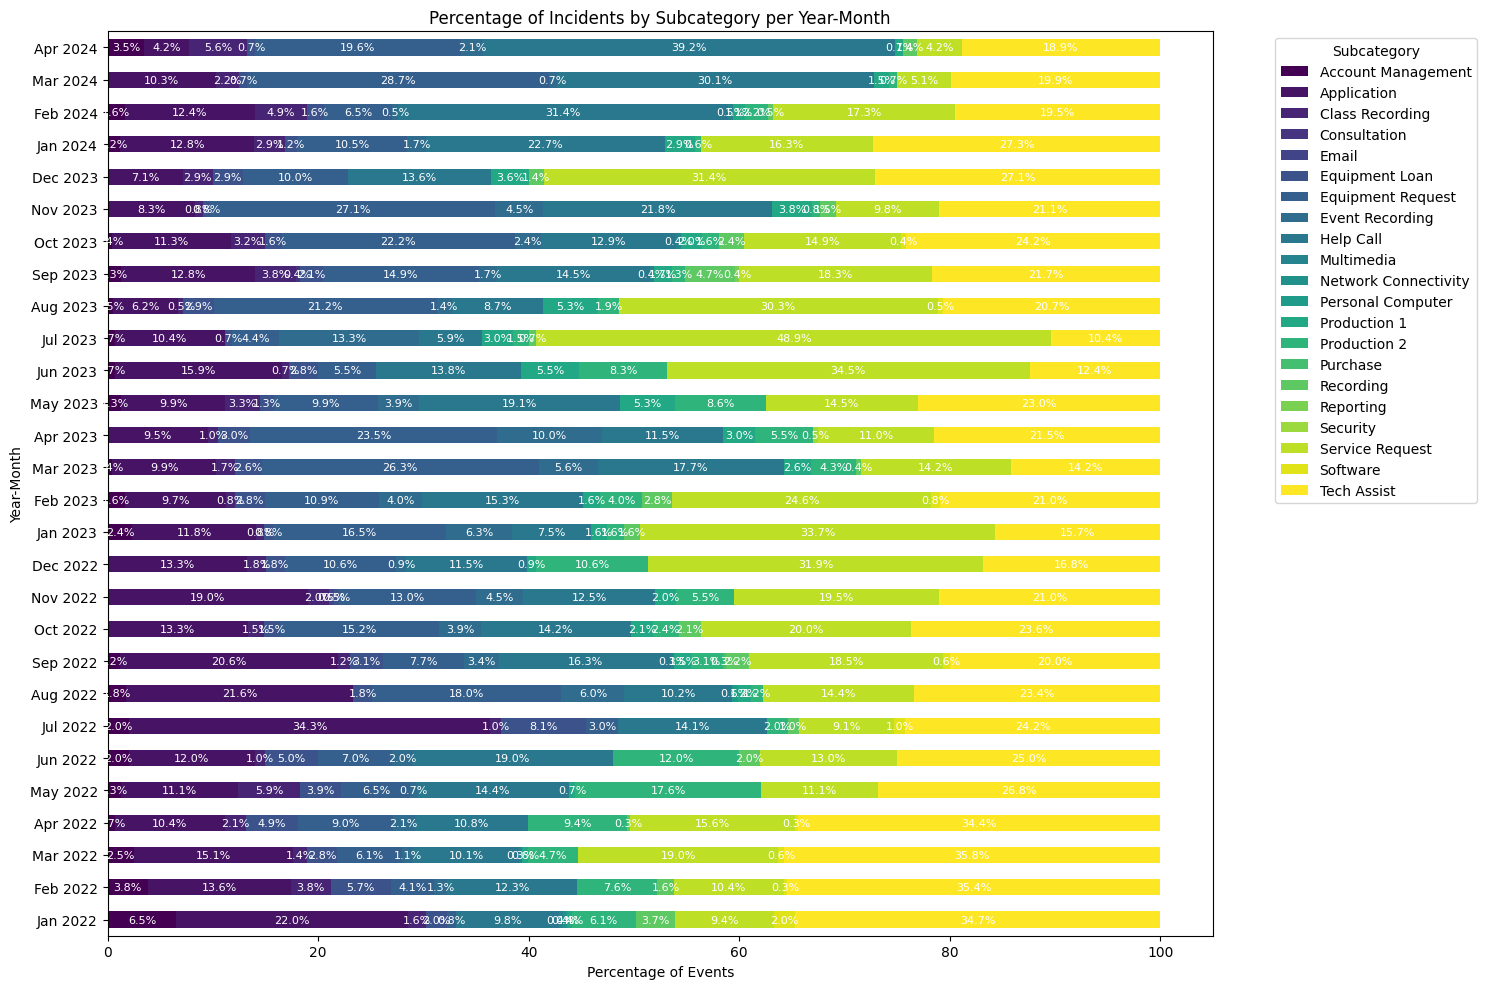

In [ ]:

# Create a 'year_month' column for a unique year-month identifier
data['year_month'] = data['opened_at'].dt.to_period('M')

# Generate a comprehensive index from the earliest to the latest month in your data
min_month = data['year_month'].min()
max_month = data['year_month'].max()
all_months = pd.period_range(min_month, max_month, freq='M')

# Group data by 'year_month' and 'subcategory', counting occurrences
subcategory_counts = data.groupby(['year_month', 'subcategory']).size().unstack(fill_value=0)

# Reindex with the comprehensive index, filling missing values with 0
subcategory_counts = subcategory_counts.reindex(all_months, fill_value=0)

# Normalize the data to get percentages for a 100% stacked bar chart
subcategory_percentages = subcategory_counts.divide(subcategory_counts.sum(axis=1), axis=0) * 100

# Plotting a 100% stacked horizontal bar chart
ax = subcategory_percentages.plot(kind='barh', stacked=True, figsize=(15, 10), colormap='viridis')

plt.title('Percentage of Incidents by Subcategory per Year-Month')
plt.xlabel('Percentage of Events')
plt.ylabel('Year-Month')
plt.yticks(ticks=np.arange(len(all_months)), labels=[ym.strftime('%b %Y') for ym in all_months])

plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding percentage labels inside each bar
for n, rect in enumerate(ax.patches):
    # Width of the bar section
    width = rect.get_width()
    if width > 0:  # Ensure that labels are only put on visible bars
        x = rect.get_x() + width / 2
        y = rect.get_y() + rect.get_height() / 2
        label = f"{width:.1f}%"  # Format label to 1 decimal place
        ax.text(x, y, label, ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()


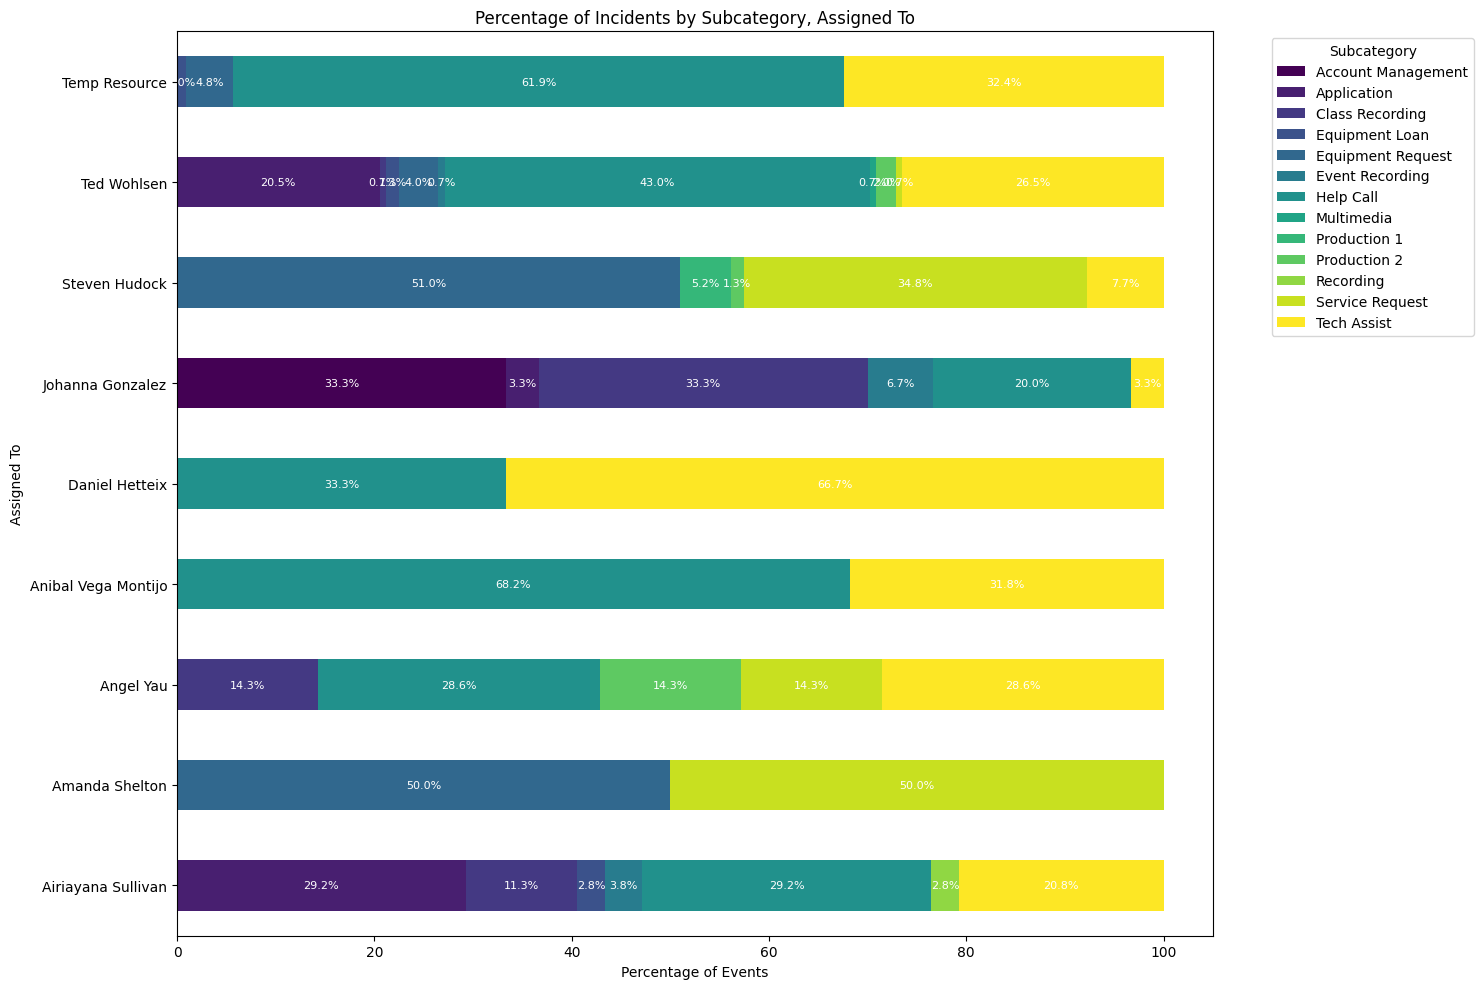

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data', 'opened_at', and 'assigned_to' are already defined
# and 'opened_at' is a datetime column.

# Filter the data to include only the records within the specified date range
start_date = pd.Timestamp('2024-01-15')
end_date = pd.Timestamp('2024-04-25')
filtered_data = data[(data['opened_at'] >= start_date) & (data['opened_at'] <= end_date)]

# Group data by 'assigned_to' and 'subcategory', counting occurrences
subcategory_counts = filtered_data.groupby(['assigned_to', 'subcategory']).size().unstack(fill_value=0)

# Normalize the data to get percentages for a 100% stacked bar chart
subcategory_percentages = subcategory_counts.divide(subcategory_counts.sum(axis=1), axis=0) * 100

# Plotting a 100% stacked horizontal bar chart
ax = subcategory_percentages.plot(kind='barh', stacked=True, figsize=(15, 10), colormap='viridis')

plt.title('Percentage of Incidents by Subcategory, Assigned To')
plt.xlabel('Percentage of Events')
plt.ylabel('Assigned To')

plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding percentage labels inside each bar
for n, rect in enumerate(ax.patches):
    # Width of the bar section
    width = rect.get_width()
    if width > 0:  # Ensure that labels are only put on visible bars
        x = rect.get_x() + width / 2
        y = rect.get_y() + rect.get_height() / 2
        label = f"{width:.1f}%"  # Format label to 1 decimal place
        ax.text(x, y, label, ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()


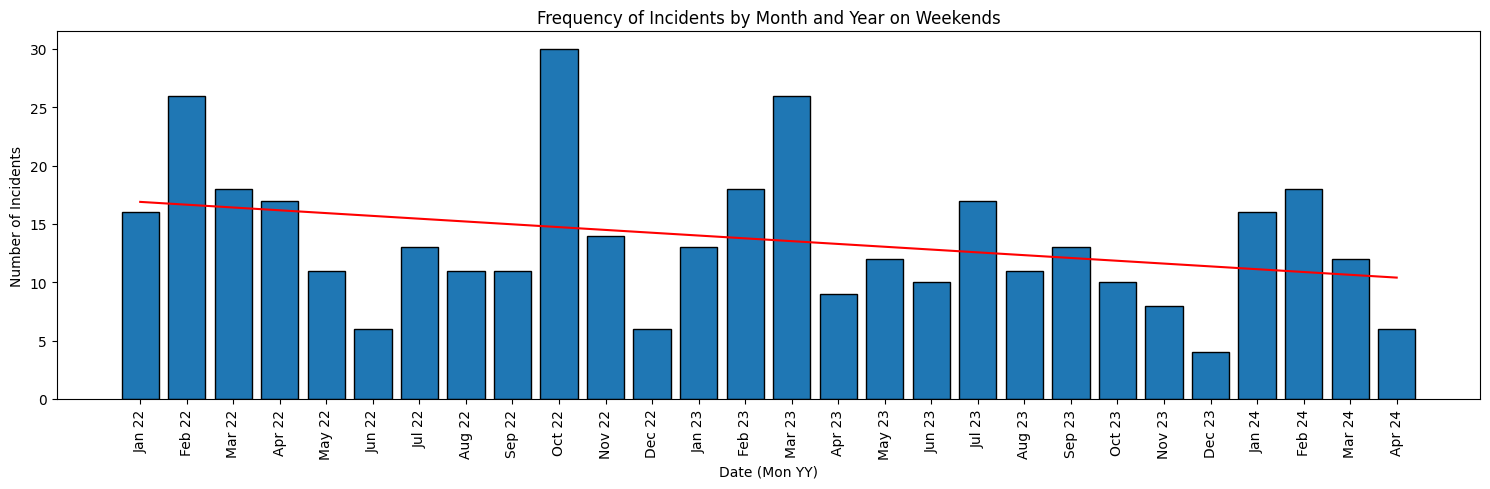

In [ ]:
# @title Frequency of Incidents by Month and Year on Weekends with Regression Trend Line

# Filter for events on Saturdays and Sundays
weekend_data = data[data['opened_at'].dt.dayofweek >= 5]

# Create a 'year_month' column for a unique year-month identifier, now using the filtered data
weekend_data['year_month'] = weekend_data['opened_at'].dt.to_period('M')

# Generate a comprehensive index from the earliest to the latest month in the filtered data
min_month = weekend_data['year_month'].min()
max_month = weekend_data['year_month'].max()
all_months = pd.period_range(min_month, max_month, freq='M')

# Count the occurrences for each month and reindex with the comprehensive index, filling missing values with 0
month_counts = weekend_data['year_month'].value_counts().reindex(all_months, fill_value=0)

# Adjusting figure size for better readability
plt.figure(figsize=(15, 5))

# Plotting the bars for weekends only, adjusting align to 'center'
plt.bar(month_counts.index.astype(str), month_counts.values, width=0.8, align='center', edgecolor='black')

# Preparing to plot the regression line
x = np.arange(len(month_counts))  # numerical x-axis for regression
y = month_counts.values  # y-axis values for regression
m, b = np.polyfit(x, y, 1)  # m = slope, b = intercept

# Calculate the y-values for the regression line, ensuring they don't fall below 0
regression_y_values = np.maximum(m*x + b, 0)

# Plot the adjusted regression line using numeric x-values
plt.plot(x, regression_y_values, color='red', label='Regression Line')

# Formatting the x-axis labels to use "Mon YY" format, ensuring labels are centered under their corresponding bars
x_labels = [date.strftime('%b %y') for date in month_counts.index.to_timestamp()]
plt.xticks(x, x_labels, rotation=90)

plt.title('Frequency of Incidents by Month and Year on Weekends')
plt.xlabel('Date (Mon YY)')
plt.ylabel('Number of Incidents')

# Adjust the margin to accommodate the rotated x-axis labels
plt.gcf().subplots_adjust(bottom=0.25)

plt.tight_layout()  # Adjust layout
plt.show()



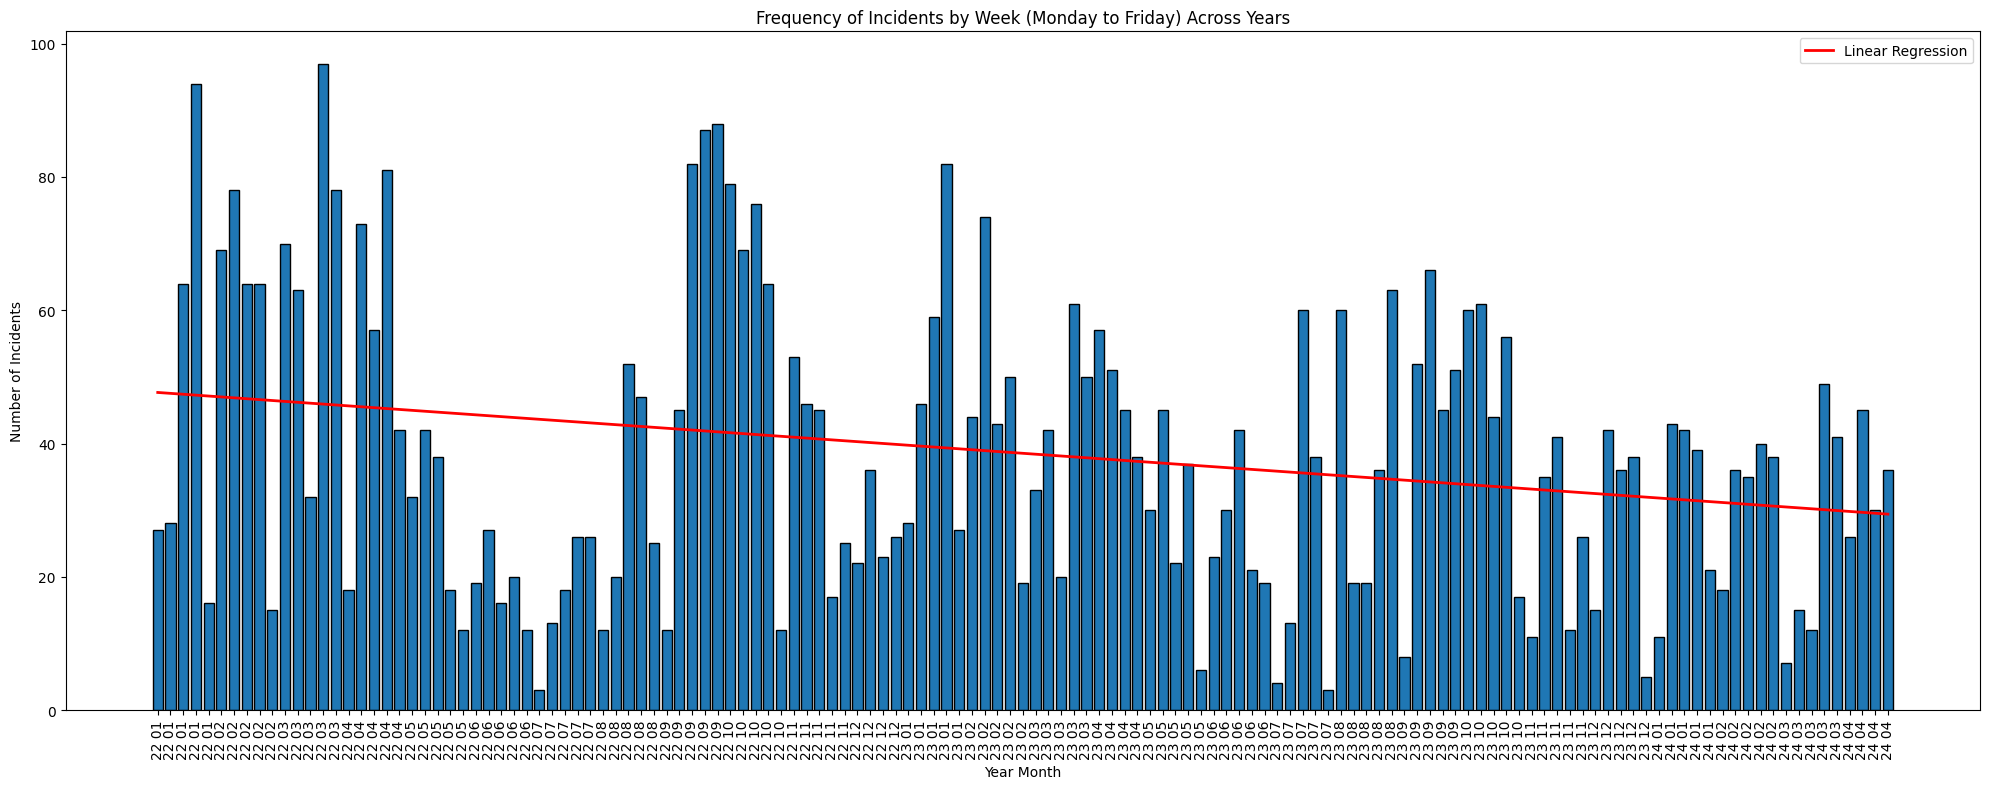

In [ ]:
# @title

# Filter for events from Monday to Friday
weekday_data = data[data['opened_at'].dt.dayofweek < 5]

# Create additional columns for year and month for labeling
weekday_data['Year'] = weekday_data['opened_at'].dt.year
weekday_data['Month'] = weekday_data['opened_at'].dt.month

# Group by year, month, and ISO week number, then count occurrences
event_counts = weekday_data.groupby([
    weekday_data['Year'],
    weekday_data['Month'],
    weekday_data['opened_at'].dt.isocalendar().week
]).size().reset_index(name='counts')

# Generate 'YY MM' labels for plotting; each point represents a week
event_counts['label'] = event_counts.apply(lambda row: f"{str(row['Year'])[2:]} {str(row['Month']).zfill(2)}", axis=1)

# Adjusting figure size for better readability
plt.figure(figsize=(20, 8))

# Plotting the bars for each week of each year; labels will repeat for multiple weeks in the same month
plt.bar(event_counts.index, event_counts['counts'], align='center', edgecolor='black')

# Prepare x and y values for regression line; using numerical index for x values
x = np.arange(len(event_counts))
y = event_counts['counts'].values

# Calculate linear regression
m, b = np.polyfit(x, y, 1)

# Plot the regression line
plt.plot(x, m*x + b, color='red', linewidth=2, label='Linear Regression')

# Set custom labels for the x-axis
plt.xticks(ticks=event_counts.index, labels=event_counts['label'], rotation=90)

plt.title('Frequency of Incidents by Week (Monday to Friday) Across Years')
plt.xlabel('Year Month')
plt.ylabel('Number of Incidents')

plt.legend()

# Adjust the margin to better accommodate the rotated x-axis labels
plt.gcf().subplots_adjust(bottom=0.3)

plt.tight_layout()
plt.show()




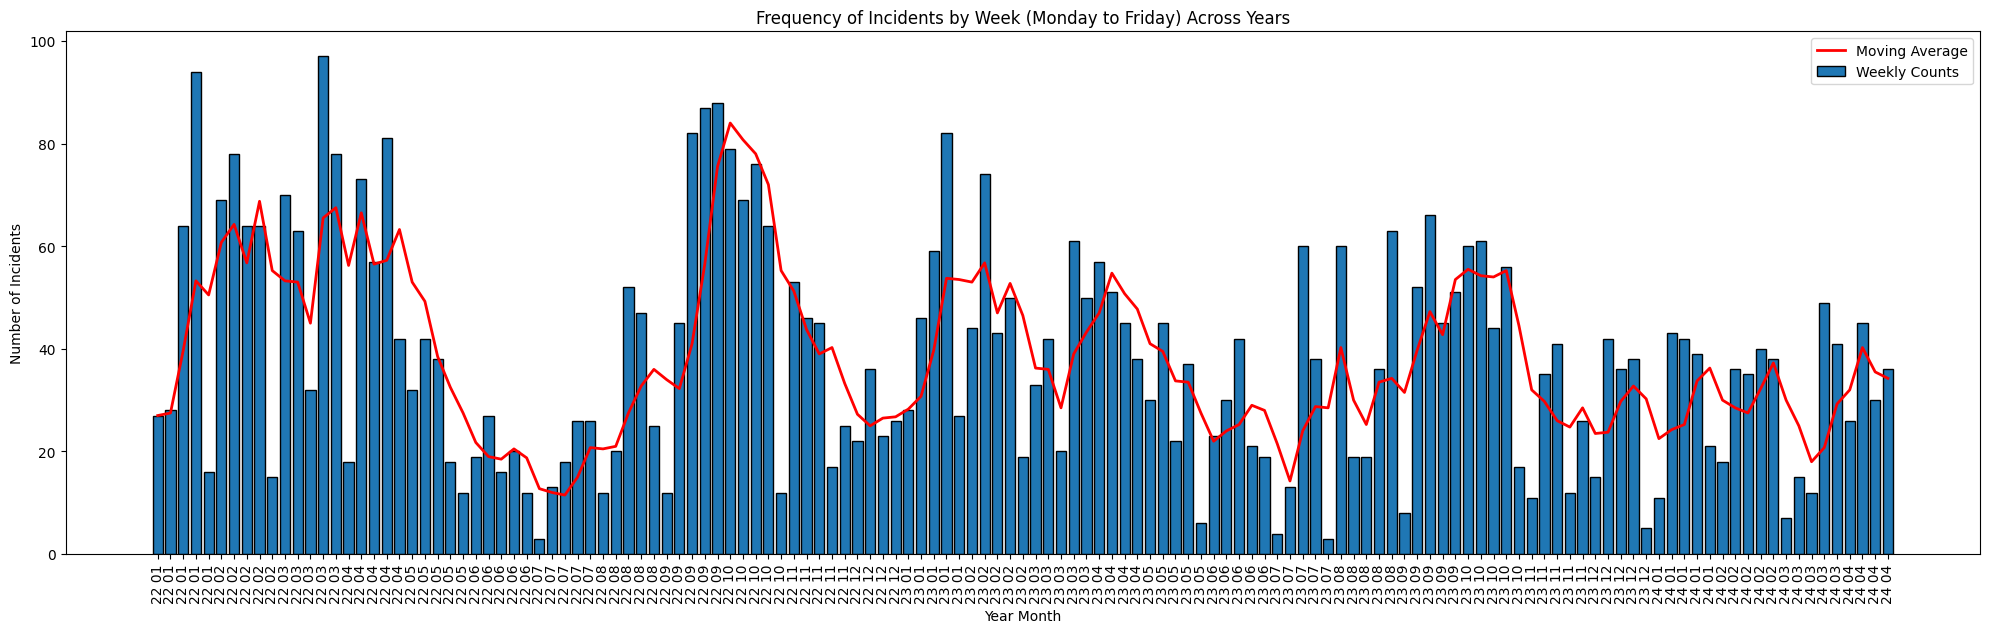

In [ ]:
# @title
# Filter for events from Monday to Friday.
weekday_data = data[data['opened_at'].dt.dayofweek < 5]

# Add necessary time components as separate columns.
weekday_data['Year'] = weekday_data['opened_at'].dt.year
weekday_data['Month'] = weekday_data['opened_at'].dt.month
weekday_data['ISOWeek'] = weekday_data['opened_at'].dt.isocalendar().week

# Group by the new columns, then count occurrences.
event_counts = weekday_data.groupby(['Year', 'Month', 'ISOWeek']).size().reset_index(name='counts')

# Generate the 'YY MM' label for plotting, without including the week number.
event_counts['label'] = event_counts.apply(lambda row: f"{str(row['Year'])[2:]} {str(row['Month']).zfill(2)}", axis=1)

# Calculate the moving average for the counts.
window_size = 4  # Adjust based on the desired smoothness.
moving_avg = event_counts['counts'].rolling(window=window_size, min_periods=1).mean()

# Plotting.
plt.figure(figsize=(20, 8))

# Plotting bars and the moving average line.
plt.bar(event_counts.index, event_counts['counts'], align='center', edgecolor='black', label='Weekly Counts')
plt.plot(event_counts.index, moving_avg, color='red', linewidth=2, label='Moving Average')

# Setting custom labels for the x-axis.
plt.xticks(ticks=event_counts.index, labels=event_counts['label'], rotation=90)

plt.title('Frequency of Incidents by Week (Monday to Friday) Across Years')
plt.xlabel('Year Month')
plt.ylabel('Number of Incidents')

plt.legend()

plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.3)  # Adjust for label visibility.

plt.show()





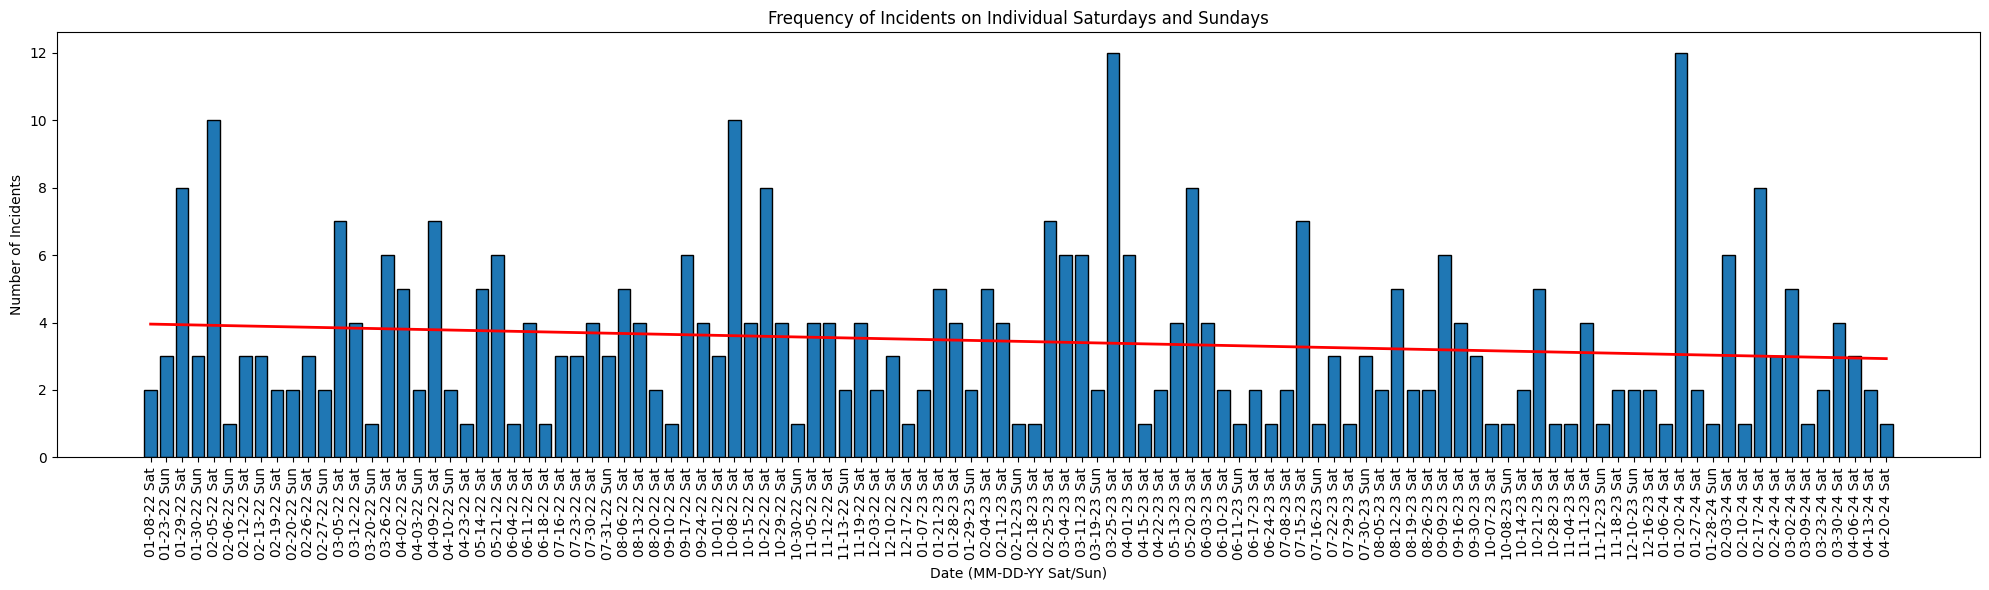

In [ ]:
# @title Incidents of Events on Individual Saturdays and Sundays with Regression Trend Line


# Filter for events on Saturdays and Sundays
weekend_data = data[data['opened_at'].dt.dayofweek >= 5]

# Counting the number of events for each individual Saturday and Sunday
event_counts_per_day = weekend_data.groupby(weekend_data['opened_at'].dt.date).size()

# Adjusting figure size for better readability
plt.figure(figsize=(20, 6))  # Increase the figure size

# Generate x-axis labels with date and whether it's Sat or Sun
x_labels = [date.strftime('%m-%d-%y') + (' Sat' if date.weekday() == 5 else ' Sun') for date in event_counts_per_day.index]

# Plotting the bars for each individual Saturday and Sunday
plt.bar(x_labels, event_counts_per_day.values, align='center', edgecolor='black')

# Since we're plotting by date, and our labels are custom, we use a simple range index for x values
x_dates = np.arange(len(event_counts_per_day))  # Using a simple range index for x values
y = event_counts_per_day.values
m, b = np.polyfit(x_dates, y, 1)  # Linear regression

# Plot the regression line
plt.plot(x_dates, m*x_dates + b, color='red', linewidth=2)

# Applying the x-axis labels and ensuring they are rotated for clarity
plt.xticks(x_dates, x_labels, rotation=90)

plt.title('Frequency of Incidents on Individual Saturdays and Sundays')
plt.xlabel('Date (MM-DD-YY Sat/Sun)')
plt.ylabel('Number of Incidents')

# Adjust the margin to better accommodate the rotated x-axis labels
plt.gcf().subplots_adjust(bottom=0.3)

plt.tight_layout()
plt.show()



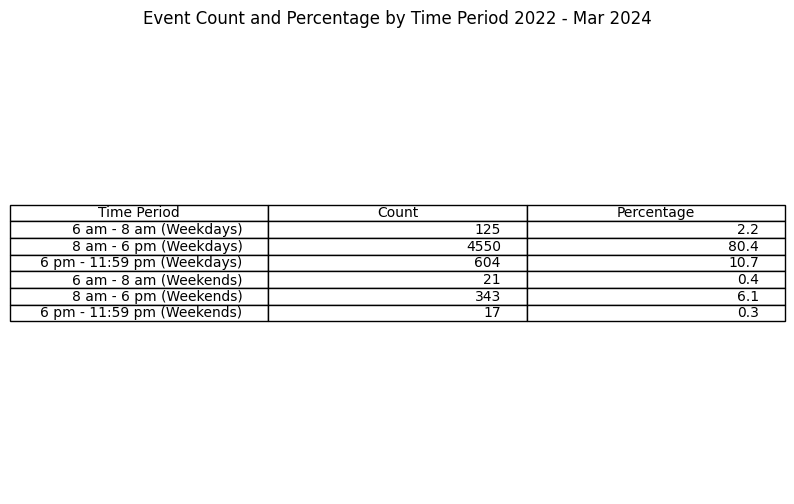

In [ ]:
# @title

# Calculate counts and percentages for each time period
total_events = len(data)

# Filter events occurring between 6 am and 8 am Monday through Friday
events_6_to_8_weekdays = data[(data['opened_at'].dt.hour >= 6) & (data['opened_at'].dt.hour < 8) &
                              (data['opened_at'].dt.weekday < 5)]
count_6_to_8_weekdays = len(events_6_to_8_weekdays)
percentage_6_to_8_weekdays = round((count_6_to_8_weekdays / total_events) * 100, 1)

# Filter events occurring between 8 am and 6 pm Monday through Friday
events_8_to_6_weekdays = data[(data['opened_at'].dt.hour >= 8) & (data['opened_at'].dt.hour < 18) &
                              (data['opened_at'].dt.weekday < 5)]
count_8_to_6_weekdays = len(events_8_to_6_weekdays)
percentage_8_to_6_weekdays = round((count_8_to_6_weekdays / total_events) * 100, 1)

# Filter events occurring between 6:01 pm and 11:59 pm Monday through Friday
events_6_to_12_weekdays = data[(data['opened_at'].dt.hour >= 18) & (data['opened_at'].dt.hour < 24) &
                               (data['opened_at'].dt.weekday < 5)]
count_6_to_12_weekdays = len(events_6_to_12_weekdays)
percentage_6_to_12_weekdays = round((count_6_to_12_weekdays / total_events) * 100, 1)

# Filter events occurring between 6 am and 8 am on Saturday and Sunday
events_6_to_8_weekends = data[(data['opened_at'].dt.hour >= 6) & (data['opened_at'].dt.hour < 8) &
                              (data['opened_at'].dt.weekday >= 5)]
count_6_to_8_weekends = len(events_6_to_8_weekends)
percentage_6_to_8_weekends = round((count_6_to_8_weekends / total_events) * 100, 1)

# Filter events occurring between 8 am and 6 pm on Saturday and Sunday
events_8_to_6_weekends = data[(data['opened_at'].dt.hour >= 8) & (data['opened_at'].dt.hour < 18) &
                              (data['opened_at'].dt.weekday >= 5)]
count_8_to_6_weekends = len(events_8_to_6_weekends)
percentage_8_to_6_weekends = round((count_8_to_6_weekends / total_events) * 100, 1)

# Filter events occurring between 6:01 pm and 11:59 pm on Saturday and Sunday
events_6_to_12_weekends = data[(data['opened_at'].dt.hour >= 18) & (data['opened_at'].dt.hour < 24) &
                               (data['opened_at'].dt.weekday >= 5)]
count_6_to_12_weekends = len(events_6_to_12_weekends)
percentage_6_to_12_weekends = round((count_6_to_12_weekends / total_events) * 100, 1)

# Create a DataFrame to display the counts and percentages for each time period
time_periods = ['6 am - 8 am (Weekdays)', '8 am - 6 pm (Weekdays)', '6 pm - 11:59 pm (Weekdays)',
                '6 am - 8 am (Weekends)', '8 am - 6 pm (Weekends)', '6 pm - 11:59 pm (Weekends)']
counts = [count_6_to_8_weekdays, count_8_to_6_weekdays, count_6_to_12_weekdays,
          count_6_to_8_weekends, count_8_to_6_weekends, count_6_to_12_weekends]
percentages = [percentage_6_to_8_weekdays, percentage_8_to_6_weekdays, percentage_6_to_12_weekdays,
               percentage_6_to_8_weekends, percentage_8_to_6_weekends, percentage_6_to_12_weekends]

table_data = {
    'Time Period': time_periods,
    'Count': counts,
    'Percentage': percentages
}

time_table = pd.DataFrame(table_data)

# Plotting the time periods table
plt.figure(figsize=(10, 6))

plt.axis('tight')
plt.axis('off')

plt.table(cellText=time_table.values, colLabels=time_table.columns, loc='center')

plt.title('Event Count and Percentage by Time Period 2022 - Mar 2024')
plt.show()


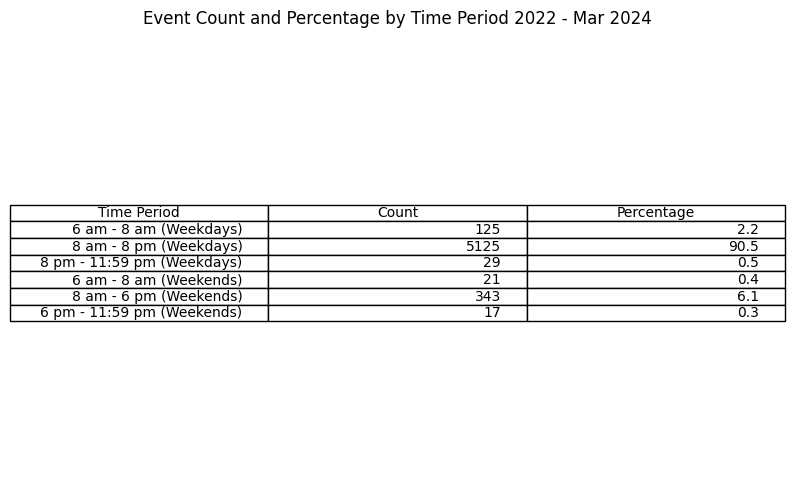

In [ ]:
# @title
# Calculate counts and percentages for each time period
total_events = len(data)

# Filter events occurring between 6 am and 8 am Monday through Friday
events_6_to_8_weekdays = data[(data['opened_at'].dt.hour >= 6) & (data['opened_at'].dt.hour < 8) &
                              (data['opened_at'].dt.weekday < 5)]
count_6_to_8_weekdays = len(events_6_to_8_weekdays)
percentage_6_to_8_weekdays = round((count_6_to_8_weekdays / total_events) * 100, 1)

# Filter events occurring between 8 am and 8 pm Monday through Friday
events_8_to_8_weekdays = data[(data['opened_at'].dt.hour >= 8) & (data['opened_at'].dt.hour < 20) &
                              (data['opened_at'].dt.weekday < 5)]
count_8_to_8_weekdays = len(events_8_to_8_weekdays)
percentage_8_to_8_weekdays = round((count_8_to_8_weekdays / total_events) * 100, 1)

# Filter events occurring between 8 pm and 11:59 pm Monday through Friday
events_8_to_12_weekdays = data[(data['opened_at'].dt.hour >= 20) & (data['opened_at'].dt.hour <= 23) &
                               (data['opened_at'].dt.weekday < 5)]
count_8_to_12_weekdays = len(events_8_to_12_weekdays)
percentage_8_to_12_weekdays = round((count_8_to_12_weekdays / total_events) * 100, 1)

# Filter events occurring between 6 am and 8 am on Saturday and Sunday
events_6_to_8_weekends = data[(data['opened_at'].dt.hour >= 6) & (data['opened_at'].dt.hour < 8) &
                              (data['opened_at'].dt.weekday >= 5)]
count_6_to_8_weekends = len(events_6_to_8_weekends)
percentage_6_to_8_weekends = round((count_6_to_8_weekends / total_events) * 100, 1)


# Create a DataFrame to display the counts and percentages for each time period
time_periods = ['6 am - 8 am (Weekdays)', '8 am - 8 pm (Weekdays)', '8 pm - 11:59 pm (Weekdays)',
                '6 am - 8 am (Weekends)', '8 am - 6 pm (Weekends)', '6 pm - 11:59 pm (Weekends)']
counts = [count_6_to_8_weekdays, count_8_to_8_weekdays, count_8_to_12_weekdays,
          count_6_to_8_weekends, count_8_to_6_weekends, count_6_to_12_weekends]
percentages = [percentage_6_to_8_weekdays, percentage_8_to_8_weekdays, percentage_8_to_12_weekdays,
               percentage_6_to_8_weekends, percentage_8_to_6_weekends, percentage_6_to_12_weekends]

table_data = {
    'Time Period': time_periods,
    'Count': counts,
    'Percentage': percentages
}

time_table = pd.DataFrame(table_data)

# Plotting the time periods table
plt.figure(figsize=(10, 6))

plt.axis('tight')
plt.axis('off')

plt.table(cellText=time_table.values, colLabels=time_table.columns, loc='center')

plt.title('Event Count and Percentage by Time Period 2022 - Mar 2024')
plt.show()


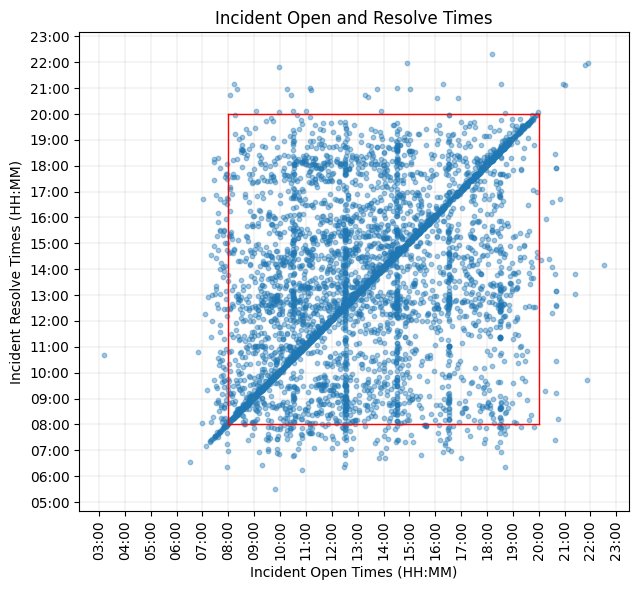

In [ ]:
# @title
# Extracting the time components and converting to minutes since midnight
start_times = data['opened_at'].dt.hour * 60 + data['opened_at'].dt.minute
end_times = data['resolved_at'].dt.hour * 60 + data['resolved_at'].dt.minute

# Plotting without jitter
plt.figure(figsize=(10, 6))
plt.scatter(start_times, end_times, alpha=0.4, s=10)  # Using original times without jitter

# Formatting the x-axis and y-axis to show time in hours:minutes format
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(60))  # Set tick marks at hourly intervals for x-axis
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(60))  # Set tick marks at hourly intervals for y-axis

def format_func(value, tick_number):
    hours = int(value // 60)
    minutes = int(value % 60)
    return f"{hours:02d}:{minutes:02d}"

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))

# Set aspect ratio to be equal to ensure equal spacing of intervals
plt.gca().set_aspect('equal', adjustable='box')

plt.title('Incident Open and Resolve Times')
plt.xlabel('Incident Open Times (HH:MM)')
plt.ylabel('Incident Resolve Times (HH:MM)')
plt.xticks(rotation=90)

# Lighter gridlines
plt.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)

# Draw a box to capture the 8 am - 8 pm interval
plt.plot([8 * 60, 8 * 60], [8 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)  # Vertical line at 8 am
plt.plot([20 * 60, 20 * 60], [8 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)  # Vertical line at 8 pm
plt.plot([8 * 60, 20 * 60], [8 * 60, 8 * 60], color='red', linestyle='-', linewidth=1)  # Horizontal line at 8 am
plt.plot([8 * 60, 20 * 60], [20 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)  # Horizontal line at 8 pm

plt.tight_layout()
plt.show()


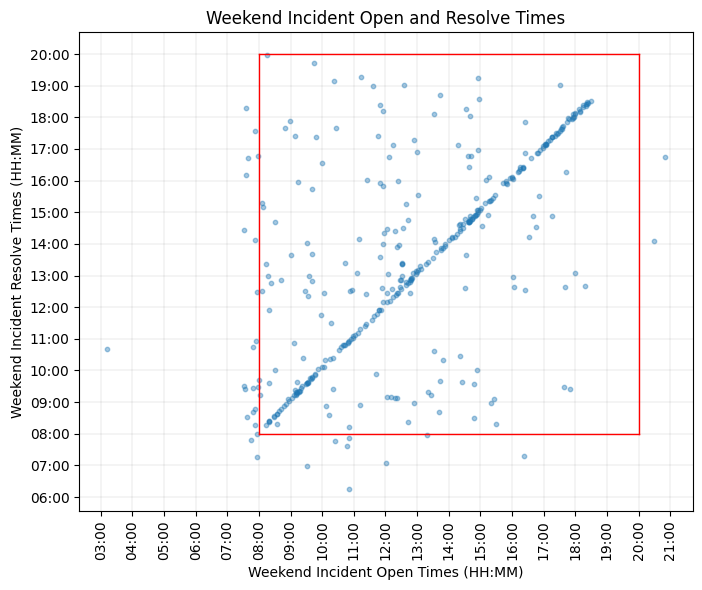

In [ ]:
# @title

# Filter the DataFrame for weekend dates
weekend_data = data[data['opened_at'].dt.weekday >= 5]

# Extracting the time components for weekend data and converting to minutes since midnight
start_times_weekend = weekend_data['opened_at'].dt.hour * 60 + weekend_data['opened_at'].dt.minute
end_times_weekend = weekend_data['resolved_at'].dt.hour * 60 + weekend_data['resolved_at'].dt.minute

# Plotting without jitter for weekend data
plt.figure(figsize=(10, 6))
plt.scatter(start_times_weekend, end_times_weekend, alpha=0.4, s=10)  # Using original times without jitter, for weekends

# Formatting the x-axis and y-axis to show time in hours:minutes format
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(60))  # Set tick marks at hourly intervals for x-axis
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(60))  # Set tick marks at hourly intervals for y-axis

def format_func(value, tick_number):
    hours = int(value // 60)
    minutes = int(value % 60)
    return f"{hours:02d}:{minutes:02d}"

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))

# Set aspect ratio to be equal to ensure equal spacing of intervals
plt.gca().set_aspect('equal', adjustable='box')

plt.title('Weekend Incident Open and Resolve Times')
plt.xlabel('Weekend Incident Open Times (HH:MM)')
plt.ylabel('Weekend Incident Resolve Times (HH:MM)')
plt.xticks(rotation=90)

# Lighter gridlines
plt.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)

# Draw a box to capture the 8 am - 8 pm interval
plt.plot([8 * 60, 8 * 60], [8 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)  # Vertical line at 8 am
plt.plot([20 * 60, 20 * 60], [8 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)  # Vertical line at 8 pm
plt.plot([8 * 60, 20 * 60], [8 * 60, 8 * 60], color='red', linestyle='-', linewidth=1)  # Horizontal line at 8 am
plt.plot([8 * 60, 20 * 60], [20 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)  # Horizontal line at 8 pm

plt.tight_layout()
plt.show()


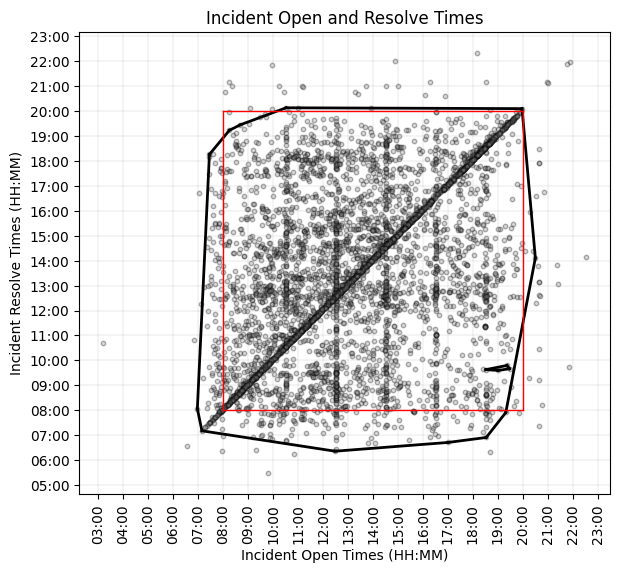

<Figure size 640x480 with 0 Axes>

In [ ]:
# @title

# Drop rows where either 'opened_at' or 'resolved_at' is NaN
data_cleaned = data.dropna(subset=['opened_at', 'resolved_at'])

# Extracting the time components and converting to minutes since midnight for the cleaned data
start_times = data_cleaned['opened_at'].dt.hour * 60 + data_cleaned['opened_at'].dt.minute
end_times = data_cleaned['resolved_at'].dt.hour * 60 + data_cleaned['resolved_at'].dt.minute

# Combining the start and end times into a single array for clustering
X = np.vstack([start_times, end_times]).T

# Applying DBSCAN clustering
dbscan = DBSCAN(eps=30, min_samples=5).fit(X)

# Plotting with clustering results
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.3, edgecolor='black', color='grey', s=10)  # Using grey for all points

# Drawing the convex hull for each cluster, except for clusters
for label in np.unique(dbscan.labels_):
    if label == -1:
        continue
    points_in_cluster = X[dbscan.labels_ == label]

    # Check if there are enough unique points for a convex hull
    if len(np.unique(points_in_cluster, axis=0)) < 3:
        continue

    try:
        hull = ConvexHull(points_in_cluster)
        for simplex in hull.simplices:
            plt.plot(points_in_cluster[simplex, 0], points_in_cluster[simplex, 1], 'k-', linewidth=2)
    except Exception as e:
        # Optionally handle cases where ConvexHull cannot be computed
        print(f"Could not compute Convex Hull for cluster {label}: {e}")

# Formatting the axes to show time in hours:minutes format
def format_func(value, tick_number):
    hours = int(value // 60)
    minutes = int(value % 60)
    return f"{hours:02d}:{minutes:02d}"

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(60))  # Set tick marks at hourly intervals for x-axis
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(60))  # Set tick marks at hourly intervals for y-axis

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))

# Set aspect ratio to be equal to ensure equal spacing of intervals
plt.gca().set_aspect('equal', adjustable='box')

plt.title('Incident Open and Resolve Times')
plt.xlabel('Incident Open Times (HH:MM)')
plt.ylabel('Incident Resolve Times (HH:MM)')
plt.xticks(rotation=90)

# Lighter gridlines
plt.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)

# Draw a box to capture the 8 am - 8 pm interval
plt.plot([8 * 60, 8 * 60], [8 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)  # Vertical line at 8 am
plt.plot([20 * 60, 20 * 60], [8 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)  # Vertical line at 8 pm
plt.plot([8 * 60, 20 * 60], [8 * 60, 8 * 60], color='red', linestyle='-', linewidth=1)  # Horizontal line at 8 am
plt.plot([8 * 60, 20 * 60], [20 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)  # Horizontal line at 8 pm

plt.show()

plt.tight_layout()
plt.show()

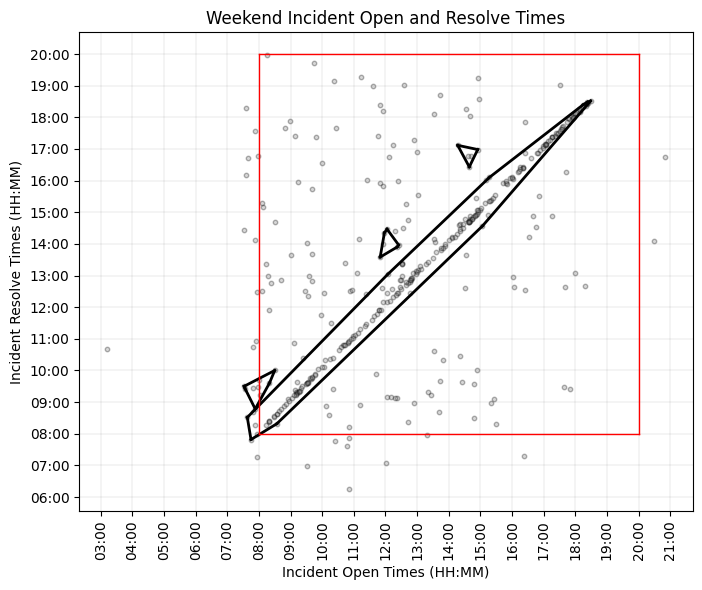

In [ ]:
# @title
# Drop rows where either 'opened_at' or 'resolved_at' is NaN
data_cleaned = data.dropna(subset=['opened_at', 'resolved_at'])

# Filter for weekend dates in the cleaned data
data_weekends = data_cleaned[data_cleaned['opened_at'].dt.weekday >= 5]

# Extracting the time components and converting to minutes since midnight for the weekend data
start_times = data_weekends['opened_at'].dt.hour * 60 + data_weekends['opened_at'].dt.minute
end_times = data_weekends['resolved_at'].dt.hour * 60 + data_weekends['resolved_at'].dt.minute

# Combining the start and end times into a single array for clustering
X = np.vstack([start_times, end_times]).T

# Applying DBSCAN clustering
dbscan = DBSCAN(eps=30, min_samples=5).fit(X)

# Plotting with clustering results for weekends
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.3, edgecolor='black', color='grey', s=10)  # Using grey for all points

# Drawing the convex hull for each cluster, except for clusters labeled as '-1' (noise)
for label in np.unique(dbscan.labels_):
    if label == -1:
        continue
    points_in_cluster = X[dbscan.labels_ == label]

    # Check if there are enough unique points for a convex hull
    if len(np.unique(points_in_cluster, axis=0)) < 3:
        continue

    try:
        hull = ConvexHull(points_in_cluster)
        for simplex in hull.simplices:
            plt.plot(points_in_cluster[simplex, 0], points_in_cluster[simplex, 1], 'k-', linewidth=2)
    except Exception as e:
        # Optionally handle cases where ConvexHull cannot be computed
        print(f"Could not compute Convex Hull for cluster {label}: {e}")

# Formatting the axes to show time in hours:minutes format
def format_func(value, tick_number):
    hours = int(value // 60)
    minutes = int(value % 60)
    return f"{hours:02d}:{minutes:02d}"

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(60))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(60))

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))

# Set aspect ratio to be equal to ensure equal spacing of intervals
plt.gca().set_aspect('equal', adjustable='box')

plt.title('Weekend Incident Open and Resolve Times')
plt.xlabel('Incident Open Times (HH:MM)')
plt.ylabel('Incident Resolve Times (HH:MM)')
plt.xticks(rotation=90)

# Lighter gridlines
plt.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)

# Draw a box to capture the 8 am - 8 pm interval
plt.plot([8 * 60, 8 * 60], [8 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)
plt.plot([20 * 60, 20 * 60], [8 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)
plt.plot([8 * 60, 20 * 60], [8 * 60, 8 * 60], color='red', linestyle='-', linewidth=1)
plt.plot([8 * 60, 20 * 60], [20 * 60, 20 * 60], color='red', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

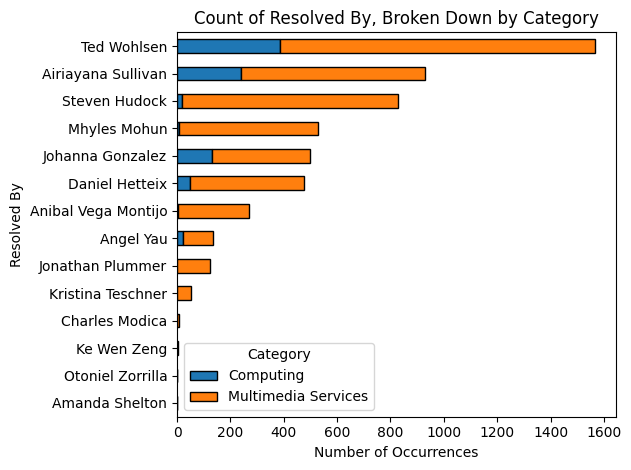

In [ ]:
# @title

# Group by 'resolved_by' and 'category', then count occurrences
resolved_by_category_counts = data.groupby(['resolved_by', 'category']).size().unstack(fill_value=0)

# Sort the DataFrame by the total occurrences to make the plot more readable
resolved_by_category_counts['Total'] = resolved_by_category_counts.sum(axis=1)
resolved_by_category_counts_sorted = resolved_by_category_counts.sort_values('Total', ascending=True).drop(columns='Total')

# Plotting the horizontal stacked bar chart
plt.figure(figsize=(10, 8))
resolved_by_category_counts_sorted.plot(kind='barh', stacked=True, edgecolor='black')
plt.xlabel('Number of Occurrences')
plt.ylabel('Resolved By')
plt.title('Count of Resolved By, Broken Down by Category')
plt.legend(title='Category')
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

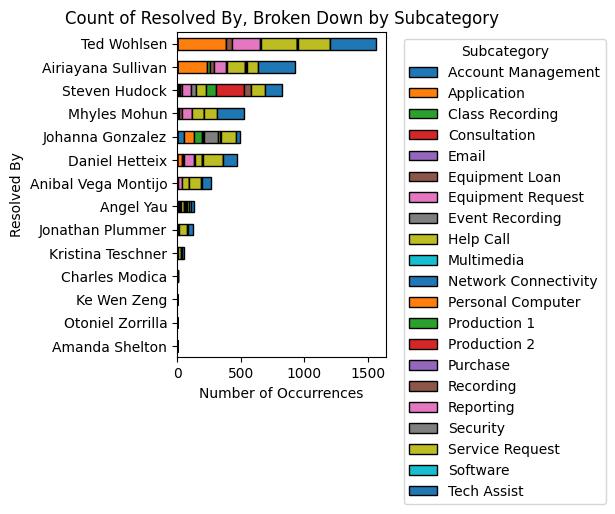

In [ ]:
# @title

# Group by 'resolved_by' and 'subcategory', then count occurrences
resolved_by_subcategory_counts = data.groupby(['resolved_by', 'subcategory']).size().unstack(fill_value=0)

# Sort the DataFrame by the total occurrences to make the plot more readable
resolved_by_subcategory_counts['Total'] = resolved_by_subcategory_counts.sum(axis=1)
resolved_by_subcategory_counts_sorted = resolved_by_subcategory_counts.sort_values('Total', ascending=True).drop(columns='Total')

# Plotting the horizontal stacked bar chart
plt.figure(figsize=(10, 8))
resolved_by_subcategory_counts_sorted.plot(kind='barh', stacked=True, edgecolor='black')
plt.xlabel('Number of Occurrences')
plt.ylabel('Resolved By')
plt.title('Count of Resolved By, Broken Down by Subcategory')
plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

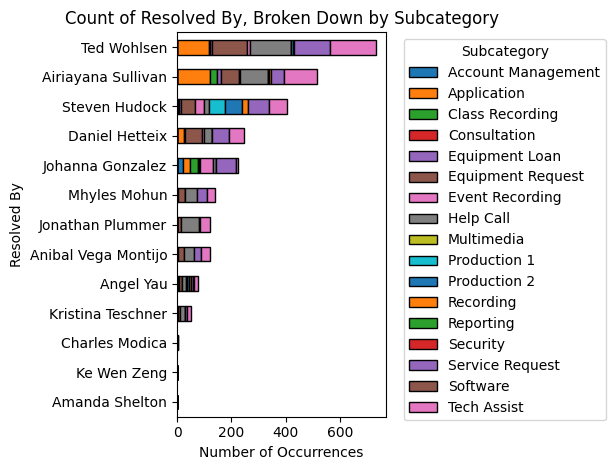

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' and 'opened_at' are already defined and 'opened_at' is a datetime column.

# Filter the data to include only the records within the specified date range
start_date = pd.Timestamp('2023-01-15')
end_date = pd.Timestamp('2024-04-25')
filtered_data = data[(data['opened_at'] >= start_date) & (data['opened_at'] <= end_date)]

# Group by 'resolved_by' and 'subcategory', then count occurrences
resolved_by_subcategory_counts = filtered_data.groupby(['resolved_by', 'subcategory']).size().unstack(fill_value=0)

# Sort the DataFrame by the total occurrences to make the plot more readable
resolved_by_subcategory_counts['Total'] = resolved_by_subcategory_counts.sum(axis=1)
resolved_by_subcategory_counts_sorted = resolved_by_subcategory_counts.sort_values('Total', ascending=True).drop(columns='Total')

# Plotting the horizontal stacked bar chart
plt.figure(figsize=(10, 8))
resolved_by_subcategory_counts_sorted.plot(kind='barh', stacked=True, edgecolor='black')
plt.xlabel('Number of Occurrences')
plt.ylabel('Resolved By')
plt.title('Count of Resolved By, Broken Down by Subcategory')
plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


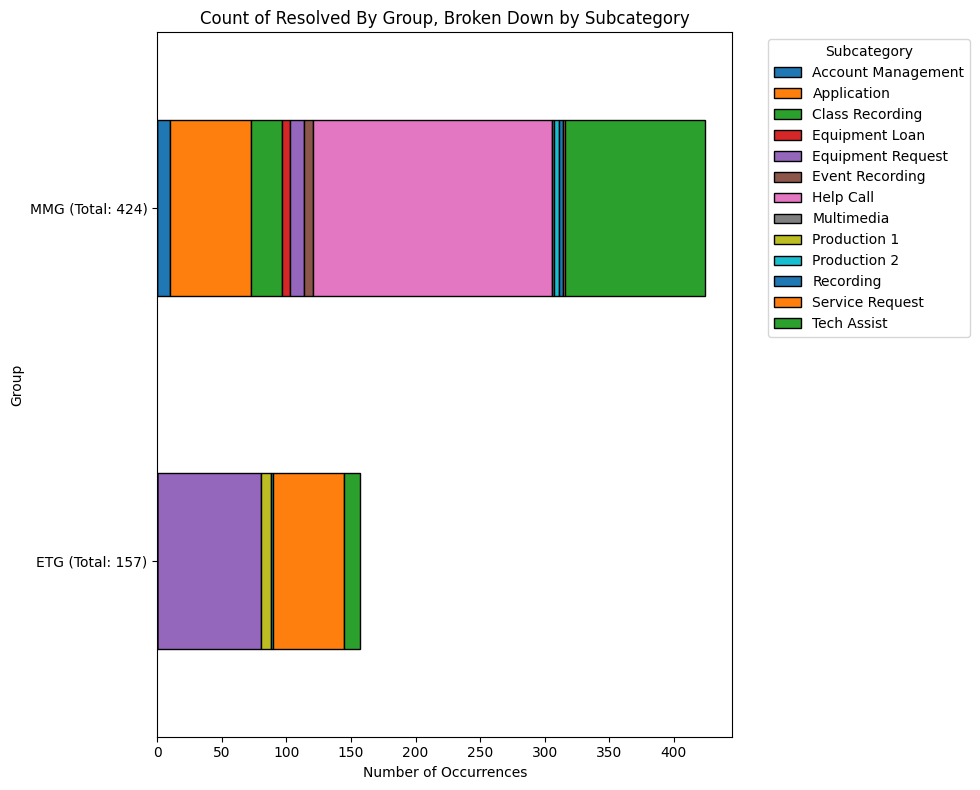

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' and 'opened_at' are already defined and 'opened_at' is a datetime column.

# Filter the data to include only the records within the specified date range
start_date = pd.Timestamp('2024-01-15')
end_date = pd.Timestamp('2024-04-25')
filtered_data = data[(data['opened_at'] >= start_date) & (data['opened_at'] <= end_date)]

# Create a new column for grouping by ETG or MMG
filtered_data['Group'] = filtered_data['assigned_to'].apply(lambda x: 'ETG' if x in ['Steven Hudock', 'Amanda Shelton'] else 'MMG')

# Group by the new 'Group' column and 'subcategory', then count occurrences
group_subcategory_counts = filtered_data.groupby(['Group', 'subcategory']).size().unstack(fill_value=0)

# Compute total counts for each group
group_totals = group_subcategory_counts.sum(axis=1)
group_labels = [f"{group} (Total: {total})" for group, total in group_totals.items()]

# Plotting the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 8))
group_subcategory_counts.plot(kind='barh', stacked=True, edgecolor='black', ax=ax)
ax.set_xlabel('Number of Occurrences')
ax.set_ylabel('Group')
ax.set_yticks(range(len(group_labels)))
ax.set_yticklabels(group_labels)  # Set the y-tick labels to include totals
ax.set_title('Count of Resolved By Group, Broken Down by Subcategory')
ax.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




<Figure size 1000x800 with 0 Axes>

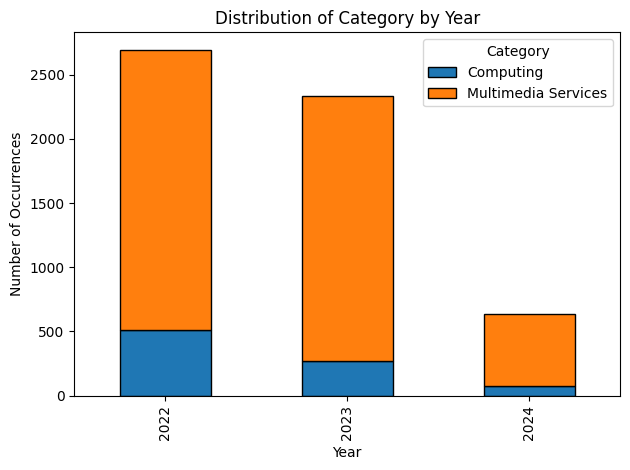

In [ ]:
# @title

# Extract the year from 'opened_at' and create a new column
data['year'] = data['opened_at'].dt.year

# Group by the extracted year and 'category', then count occurrences
category_year_distribution = data.groupby(['year', 'category']).size().unstack(fill_value=0)

# Plotting the distribution of 'category' by year
plt.figure(figsize=(10, 8))
category_year_distribution.plot(kind='bar', stacked=True, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Category by Year')
plt.legend(title='Category')
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

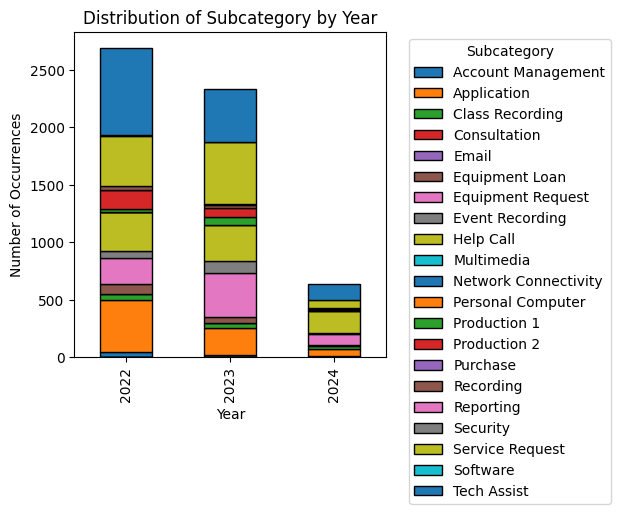

In [ ]:
# @title

# Extract the year from 'opened_at' and create a new column
data['year'] = data['opened_at'].dt.year

# Group by the extracted year and 'subcategory', then count occurrences
subcategory_year_distribution = data.groupby(['year', 'subcategory']).size().unstack(fill_value=0)

# Plotting the distribution of 'subcategory' by year
plt.figure(figsize=(10, 8))
subcategory_year_distribution.plot(kind='bar', stacked=True, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Subcategory by Year')
plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
